# ML Course 2023 |  Sentiment Analysis in Twitter Challenge
You can check the updated leaderboard in this [link](https://nimble-hellebore-184.notion.site/ML-Course-2023-Sentiment-Analysis-in-Twitter-Challenge-966b041e7aec4f2eabbc8dc33d64b871).

In [ ]:
!pip3 install tueplots==0.0.5
!pip3 install sentence-transformers==2.2.2


In [ ]:
!pip3 install WordCloud
!pip3 install seaborn
!pip3 install -U imbalanced-learn
!pip3 install xgboost


# Load Tweets

The dataframe of tweets contain the following columns:

- `id`: The unique identifier of the tweet
- `text`: The content of the tweet
- `type`: The type of tweet, which can be 'tweet', 'quoted', 'retweeted' or 'quoted__replied_to'
- `author_id`: The unique identifier of the author of the tweet
- `possibly_sensitive`: A boolean value indicating whether the tweet contains sensitive content
- `retweet_count`: The number of times the tweet has been retweeted
- `quote_count`: The number of times the tweet has been quoted
- `reply_count`: The number of times the tweet has been replied to
- `like_count`: The number of times the tweet has been liked
- `followers_count`: The number of followers of the author of the tweet
- `following_count`: The number of accounts the author of the tweet is following
- `tweet_count`: The total number of tweets made by the author of the tweet
- `listed_count`: The number of lists the author of the tweet is a member of
- `score_compound`:  A numerical value ranging from -1 to 1 indicating the overall sentiment of the tweet, where -1 represents  negative sentiment and 1 represents positive sentiment. **This is the target variable for the regression task.**
- `sentiment`: A categorical variable indicating the sentiment of the tweet, which can be 'negative', 'neutral' or 'positive'. **This is the target variable for the classification task.**




In [1]:
import os
import pandas as pd
pd.set_option('display.max_rows', 100)

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
import tueplots.constants.color.palettes as tue_palettes

from sentence_transformers import SentenceTransformer

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import numpy as np


In [273]:
team_id = '19' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('tweets_train.csv') # we are subsampling 100 training data
df_test = pd.read_csv(f'tweets_{split}.csv') # we are subsampling 200 test data


In [274]:
df[df.type == 'tweet'].head()

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words,score_compound,sentiment
7,1585623984858869765,Postdoctoral position available in Computation...,tweet,62044012,False,18,1,0,68,33022,3383,5246,359,"['postdoctoral', 'position', 'available', 'com...",0.4404,neutral
20,708862256482627585,Game 4 about to start shortly. Livestream here...,tweet,1482581556,False,82,0,9,140,282492,99,1468,4681,"['game', 'start', 'shortly', 'livestream', 'ro...",0.0000,neutral
21,1623716638205050881,For all Hebrew speaking readers of our channel...,tweet,3363584909,False,4,0,2,23,65506,113,15406,856,"['hebrew', 'speaking', 'readers', 'channel', '...",0.4404,neutral
24,1114304151809224704,My former student Ian Goodfellow moving to App...,tweet,216939636,False,308,27,29,2631,744556,670,1510,9898,"['former', 'student', 'ian', 'goodfellow', 'mo...",0.8910,positive
25,796222629208145920,"Whatever happens tonight, when you wake up tom...",tweet,216939636,False,712,44,20,1435,744556,670,1510,9898,"['whatever', 'happens', 'tonight', 'wake', 'to...",0.4404,neutral


In [275]:
df_test.head()

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words
0,1594715340231290880,"You allege, @ylecun. that there are zero cases...",quoted,232294292,False,6,2,8,61,86646,5312,26291,2422,"['allege', 'zero', 'cases', 'llms', 'created',..."
1,1549261742349291520,I've scanned the TOC and Introduction and I ha...,quoted,3363584909,False,3,0,1,29,65506,113,15406,856,"['scanned', 'toc', 'introduction', 'strong', '..."
2,1353027631130832896,Automatic differentiation is really pretty fan...,tweet,175624200,False,41,5,13,557,1031629,225,16316,6967,"['automatic', 'differentiation', 'really', 'pr..."
3,1603885102890733569,@__lucab Rienzi is especially great,replied_to,62044012,False,0,0,0,0,33022,3383,5246,359,"['rienzi', 'especially', 'great']"
4,1544232610343243776,To complete my story about the Kielce Pogrom\n...,quoted,3363584909,False,0,0,1,14,65506,113,15406,856,"['complete', 'story', 'kielce', 'pogrom', 'pic..."


# Pre-process tweets

The following are the preprocessing steps we followed to get the `words` column from the original tweet, which corresponds to the `text` column of the dataframe.

- Remove punctuations, special characters, mentions, links, and numbers from the tweets.
- Convert all the tweets to lowercase.
- Tokenize the tweets into individual words.
- Remove stop words, such as "and", "the", "a", etc.
- Perform stemming or lemmatization on the remaining words to convert them to their base form.
- Filter out any words that occur infrequently in the corpus to reduce the dimensionality of the data.
- Create a bag of words representation of the tweets, where each tweet is represented as a vector of word frequencies.


**Note:** Lemmatization is a process in natural language processing where words are reduced to their base form, or lemma. This is done by removing inflections, such as pluralization or verb conjugation, and converting the word to its dictionary form. The result of this process is a word that is more easily recognizable, and can be used to improve the accuracy of NLP models, such as the LDA model. By lemmatizing the words in a corpus of text, the dimensionality of the data is reduced, and the relationships between words become clearer, making it easier to identify patterns and themes within the text.


In [276]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))


In [277]:
df['words'].head()

0                                  ['british', 'alps']
1    ['videos', 'presentations', 'papers', 'keynote...
2    ['hope', 'would', 'able', 'talk', 'balcony', '...
3    ['keynote', 'joan', 'bruna', 'geometric', 'dee...
4    ['process', 'science', 'relies', 'much', 'basi...
Name: words, dtype: object

In [278]:
df['words_str'].head()

0                                         british alps
1    videos presentations papers keynote talks aist...
2    hope would able talk balcony tomorrow pm et al...
3    keynote joan bruna geometric deep learning pro...
4    process science relies much basic honesty part...
Name: words_str, dtype: object

# Preprocessing data

The following processes are used to reduce the dimension of the variables and to normalize all the values

In [282]:
df_wo_label = df.drop(['sentiment', 'words', 'words_str', 'text', 'type', 'possibly_sensitive'], axis = 1)

In [283]:
df_test_wo_label = df_test.drop(['words', 'words_str', 'text', 'type', 'possibly_sensitive'], axis = 1)

In [284]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [285]:
# better to do it every time we train and validate the model
df_norm = preprocessing.StandardScaler().fit_transform(df_wo_label)

# Visualize content of the tweets

Join all of the preprocessed tweets together and create a world cloud of them to see most frequently used words among all tweets.

In [ ]:
long_string = ','.join(list(df['words_str'].values))
# Create a WordCloud object
wordcloud = WordCloud(font_path = 'C:/Users/bodhi/AppData/Local/Microsoft/Windows/Fonts/times.ttf', background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Sentiment Analysis

**In this part, we will visualize the distribution of these possible sentiments in our dataset.**

Each tweet in our dataset have one of three sentiments (`sentiment`):

*   Positive
*   Neutral
*   Negative

Also, each tweet has a continous score (`score_compound`) between [-1,1] where -1 corresponds to negative and 1 corresponds to a positive sentinement.

In [12]:
df_pos = df[df.sentiment == 'positive']
df_neu = df[df.sentiment == 'neutral']
df_neg = df[df.sentiment == 'negative']


num_total = len(df)
num_pos = len(df_pos)
num_neu = len(df_neu)
num_neg = len(df_neg)

print(f"Num. positive tweets: {num_pos} ({num_pos/num_total*100:.2f}%)")
print(f"Num. negative tweets: {num_neg} ({num_neg/num_total*100:.2f}%)")
print(f"Num. neutral tweets: {num_neu} ({num_neu/num_total*100:.2f}%)")


Num. positive tweets: 2228 (27.85%)
Num. negative tweets: 482 (6.02%)
Num. neutral tweets: 5290 (66.12%)


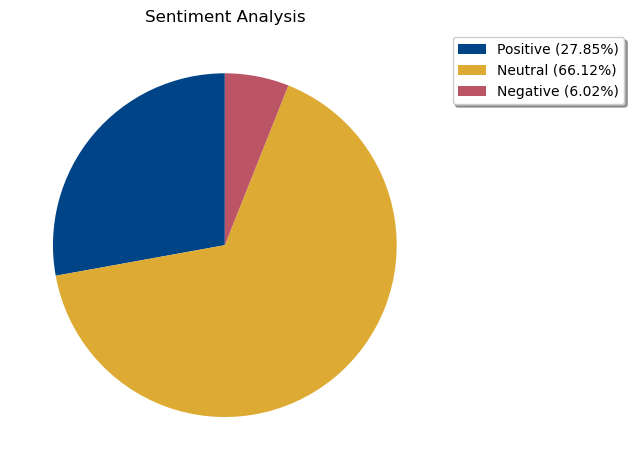

In [13]:
plt.close('all')

fig, ax = plt.subplots(1, 1)

labels = []
labels.append(f"Positive ({num_pos/num_total*100:.2f}%)")
labels.append(f"Neutral ({num_neu/num_total*100:.2f}%)")
labels.append(f"Negative ({num_neg/num_total*100:.2f}%)")

sizes = [num_pos, num_neu, num_neg]

colors = [f"#{i}" for i in tue_palettes.high_contrast[:3]]

_ = ax.pie(sizes,colors=colors, startangle=90)
# plt.style.use(default’)
ax.legend(labels,
          loc='upper center', 
          bbox_to_anchor=(1.23, 1.0), 
          fancybox=True, 
          shadow=True)

ax.set_title("Sentiment Analysis")
plt.tight_layout()
plt.show()

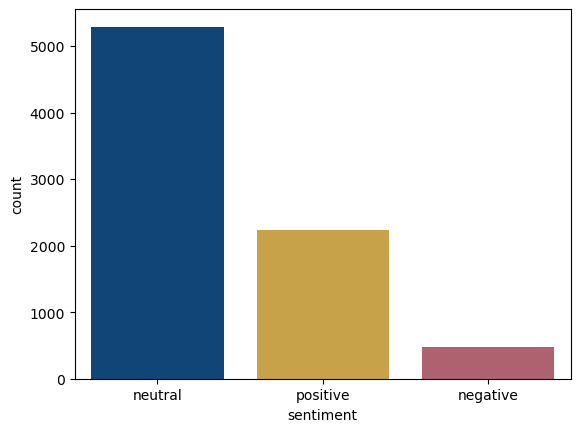

In [14]:
plt.close('all')

sns.countplot(x=df.sentiment, palette=colors)
plt.show()

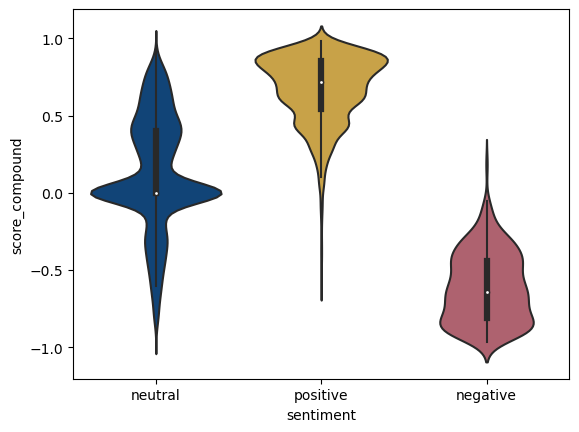

In [15]:
plt.close('all')

sns.violinplot(data=df, x='sentiment', y='score_compound', palette=colors)
plt.show()

# Check the correlation between data and target

In [287]:
from scipy.stats import shapiro

In [288]:
df_norm = pd.DataFrame(np.squeeze(df_norm), columns=list(df_wo_label.columns))

In [18]:
df_norm

,id,author_id,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,score_compound
0,0.424004,-0.181818,-0.070380,-0.12296,-0.167816,-0.083141,-0.526714,1.120608,-0.728350,-1.211881,-0.516603
1,-0.241207,5.500000,-0.057001,-0.12296,-0.182349,-0.083584,-0.537650,-0.403988,-1.255952,-1.253184,-0.516603
2,0.521226,-0.181818,-0.070123,-0.12296,-0.182349,-0.082919,-0.503724,-0.633590,0.451584,-1.062045,0.555099
3,0.245749,-0.181818,-0.061375,-0.12296,-0.182349,-0.083584,-0.534623,-0.396478,-1.181277,-1.240522,0.279569
4,0.663480,-0.181818,-0.070380,-0.12296,-0.167816,-0.082476,-0.247280,-0.381994,0.166240,0.635901,-1.217993
...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.219960,-0.181818,-0.070380,-0.12296,-0.182349,-0.083141,0.180035,-0.573507,0.557267,0.780310,-0.516603
7996,0.623109,-0.181818,-0.052884,-0.12296,-0.182349,-0.083584,-0.350155,-0.641100,-1.167108,0.091123,0.184787
7997,0.461154,-0.181818,-0.056229,-0.12296,-0.182349,-0.083584,-0.534623,-0.396478,-1.181277,-1.240522,-0.516603
7998,-0.111643,-0.181818,-0.070380,-0.12296,-0.153283,-0.077825,0.180035,-0.573507,0.557267,0.780310,0.959578


In [19]:
# using spearman because the data is not normally distributed
correlation = df_norm.corr('spearman')

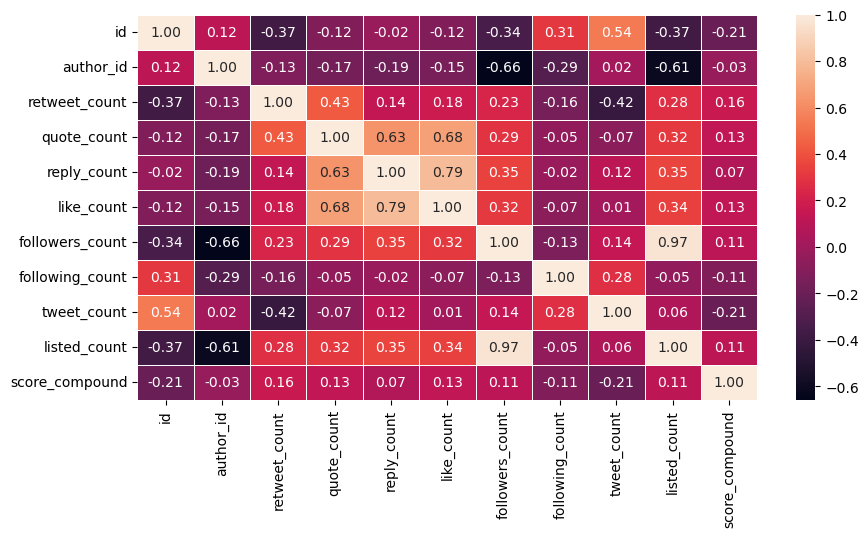

In [20]:
plt.figure(figsize=(10,5), dpi =100)
sns.heatmap(correlation,annot=True,fmt=".2f", linewidth=.5)
plt.show()

the correlation between each categories and the score compound is not very strong, but maybe it could help a little bit on our result later.

# Using PCA

In [21]:
from sklearn.decomposition import PCA, FastICA

In [22]:
df_pca = PCA(n_components = 0.95, whiten = True).fit(df_norm.drop(['score_compound'], axis = 1))

In [23]:
df_pca.explained_variance_ratio_

array([0.30314973, 0.20528621, 0.13179466, 0.0974782 , 0.07522493,
       0.05693383, 0.04183918, 0.03767138, 0.02879841])

to get 95% of the variance, we need 9 dimension, which is just the total -1. I do not think using PCA will be useful

# PLOT that may be useful

# Obtain the text embeddings

When working with natural language processing tasks, such as text classification, it is common to use word embeddings to represent the meaning of words and sentences. Word embeddings are dense vectors that capture the semantic relationships between words in a way that allows for easier processing by machine learning algorithms.

The process of creating word embeddings involves training a neural network on a large corpus of text data. However, pre-trained word embeddings are readily available online and can be downloaded and used in your projects. See a complete list of pre-trained models [here](https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md). 


**Note:** When working with pre-trained models, it is important to keep in mind the computational resources required to generate the embeddings. Depending on the size of the model and the amount of text data being processed, generating embeddings may take a significant amount of time. Therefore, it is advisable to save the embeddings locally once they have been generated, to avoid the need to re-generate everytime you may want to make changes in the model (but not in the embedding).



In [24]:
# name = 'stsb-distilbert-base'
# name = 'all-mpnet-base-v2'
name = 'stsb-mpnet-base-v2'
# name = 'bert-base-nli-mean-tokens'
# name = 'average_word_embeddings_komninos'
model = SentenceTransformer(name)


In [ ]:
sentences = list(df.words_str.values)
sentence_embeddings = model.encode(sentences)
np.save('stsb_mpnet_base_v2_embeddings_all.npy', sentence_embeddings)

In [25]:
sentence_embeddings = np.load("stsb_mpnet_base_v2_embeddings_all.npy")

In [26]:
sentence_embeddings.shape

(8000, 768)

Aside from the sentence embeddings, we can try to use another nlp method to vectorize the words with "Bag of Words" method and "Gram" method. 

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [28]:
count_vector = {
    'words11g.pkl': None,
    'words11g100.pkl': None,
    'words11g500.pkl': None,
    'words11g1000.pkl': None,
    'words11g2500.pkl': None,
    'words11g5000.pkl': None,
    'words22g100.pkl' : None,
    'words22g500.pkl' : None,
    'words22g1000.pkl' : None,
    'words22g2500.pkl' : None,
    'words22g5000.pkl' : None,
    'words22g10000.pkl' : None,
    'words22g20000.pkl' : None,
    'words22g25000.pkl' : None,
    'words22g30000.pkl' : None,
    'words22g40000.pkl' : None,
    'words22g50000.pkl' : None,
    'words22g60000.pkl' : None,
    'words22g70000.pkl' : None,
    'words22g80000.pkl' : None,
    'words33g.pkl' : None,
    'words33g100.pkl' : None,
    'words33g500.pkl' : None,
    'words33g2500.pkl' : None,
    'words33g1000.pkl' : None,
    'words33g5000.pkl' : None,
    'words33g10000.pkl' : None,
    'words33g25000.pkl' : None,
    'words33g50000.pkl' : None,
    'words33g75000.pkl' : None,
    'words12g.pkl' : None,
    'words12g100.pkl' : None,
    'words12g500.pkl' : None,
    'words12g1000.pkl' : None,
    'words12g2500.pkl' : None,
    'words12g5000.pkl' : None,
    'words12g10000.pkl' : None,
    'words12g25000.pkl' : None,
    'words12g50000.pkl' : None,
    'words12g75000.pkl' : None,
    'words23g.pkl' : None,
    'words23g100.pkl' : None,
    'words23g500.pkl' : None,
    'words23g1000.pkl' : None,
    'words23g2500.pkl' : None,
    'words23g5000.pkl' : None,
    'words23g10000.pkl' : None,
    'words23g25000.pkl' : None,
    'words23g50000.pkl' : None,
    'words23g75000.pkl' : None,
    'words23g100000.pkl' : None,
    'words23g125000.pkl' : None,
    'words23g150000.pkl' : None,
    'words13g.pkl' : None,
    'words13g100.pkl' : None,
    'words13g500.pkl' : None,
    'words13g1000.pkl' : None,
    'words13g2500.pkl' : None,
    'words13g5000.pkl' : None,
    'words13g10000.pkl' : None,
    'words13g25000.pkl' : None,
    'words13g50000.pkl' : None,
    'words13g75000.pkl' : None,
    'words13g100000.pkl' : None,
    'words13g125000.pkl' : None,
    'words13g150000.pkl' : None,
    

}


We will analyze this. First we make few comparisons between BoW with 1-gram, 2-gram, 3-gram, and the union of each categories and also we will look at the top 10% words.

In [29]:
count_vector

{'words11g.pkl': None,
 'words11g100.pkl': None,
 'words11g500.pkl': None,
 'words11g1000.pkl': None,
 'words11g2500.pkl': None,
 'words11g5000.pkl': None,
 'words22g100.pkl': None,
 'words22g500.pkl': None,
 'words22g1000.pkl': None,
 'words22g2500.pkl': None,
 'words22g5000.pkl': None,
 'words22g10000.pkl': None,
 'words22g20000.pkl': None,
 'words22g25000.pkl': None,
 'words22g30000.pkl': None,
 'words22g40000.pkl': None,
 'words22g50000.pkl': None,
 'words22g60000.pkl': None,
 'words22g70000.pkl': None,
 'words22g80000.pkl': None,
 'words33g.pkl': None,
 'words33g100.pkl': None,
 'words33g500.pkl': None,
 'words33g2500.pkl': None,
 'words33g1000.pkl': None,
 'words33g5000.pkl': None,
 'words33g10000.pkl': None,
 'words33g25000.pkl': None,
 'words33g50000.pkl': None,
 'words33g75000.pkl': None,
 'words12g.pkl': None,
 'words12g100.pkl': None,
 'words12g500.pkl': None,
 'words12g1000.pkl': None,
 'words12g2500.pkl': None,
 'words12g5000.pkl': None,
 'words12g10000.pkl': None,
 'words

this has more than 16k unique words, I think we will analyze using 100, 500, 1000, 2500, 5000 top words

In [30]:

def save_pickle(file_name):
    with open('count_vectorizer/'+ file_name, 'wb') as f:
        pickle.dump(count_vector[file_name], f)
        
def load_pickle(file_name):
    with open('count_vectorizer/'+ file_name, 'rb') as f:
        count_vector[file_name] = pickle.load(f)


for key in count_vector.keys():
    try:
        load_pickle(key)
    except:
        ngram = (int(key[5]), int(key[6]))
        max_feature = key[key.find('g') + 1:key.find('.')]
        try:
            count_vector[key] = CountVectorizer(ngram_range = ngram, max_features = int(max_feature)).fit_transform(df['words_str'])
        except:
            count_vector[key] = CountVectorizer(ngram_range = ngram).fit_transform(df['words_str'])
        finally:
            save_pickle(key)
        

In [31]:
count_vector

{'words11g.pkl': <8000x16166 sparse matrix of type '<class 'numpy.int64'>'
 	with 100563 stored elements in Compressed Sparse Row format>,
 'words11g100.pkl': <8000x100 sparse matrix of type '<class 'numpy.int64'>'
 	with 19303 stored elements in Compressed Sparse Row format>,
 'words11g500.pkl': <8000x500 sparse matrix of type '<class 'numpy.int64'>'
 	with 41833 stored elements in Compressed Sparse Row format>,
 'words11g1000.pkl': <8000x1000 sparse matrix of type '<class 'numpy.int64'>'
 	with 54939 stored elements in Compressed Sparse Row format>,
 'words11g2500.pkl': <8000x2500 sparse matrix of type '<class 'numpy.int64'>'
 	with 72939 stored elements in Compressed Sparse Row format>,
 'words11g5000.pkl': <8000x5000 sparse matrix of type '<class 'numpy.int64'>'
 	with 85164 stored elements in Compressed Sparse Row format>,
 'words22g100.pkl': <8000x100 sparse matrix of type '<class 'numpy.int64'>'
 	with 1978 stored elements in Compressed Sparse Row format>,
 'words22g500.pkl': <8

we see that we have a lot of unique words. This of course eats a lot of computational power, so we will analyze it further with 10%, 25% of datasets

we will use linear regression to analyze this.

In [ ]:
def test_model(strategy, model, X, y):
    sum_rmse = 0
    length = 0
    for (train, test) in strategy.split(X, y):
#         do i need to normalize the input ? I do not think so ?
        
#         fitting the model
        reg = model.fit(X[train], y[train])
        y_pred = reg.predict(X[test])
        
#         calculating the accuracy
        rmse = np.sqrt(skm.mean_squared_error(y[test], y_pred))
        sum_rmse += rmse
        length += 1
    return sum_rmse/length
#     print("\n strategy = ", strategy, "\n model = ", model, "\n avg_rmse = ", sum_rmse / length)


In [32]:
#strategy for model selection
kf5 = KFold(n_splits = 5)
kf10 = KFold(n_splits = 10)

NameError: name 'KFold' is not defined

In [ ]:
lr = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

In [ ]:
rmse_vector = dict()
for key in count_vector:
    rmse = test_model(kf10, lr, count_vector[key], df['score_compound'])
    rmse_vector[key] = rmse
rmse_vector

In [ ]:
# this is just example, in reality i will not use this.
# make data
x = list(rmse_vector.keys())
y = rmse_vector.values()

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (100,30)
# ax.stem(x, y)
markerline, stemlines, baseline = ax.stem(x, y)
plt.setp(stemlines, 'linewidth', 30)
plt.savefig('res.jpg')
plt.show()

In [ ]:
print("TOP 5 RMSE \n")
for e in sorted(rmse_vector, key=rmse_vector.get)[:5]:
    print(e + " = " + str(rmse_vector[e]))

trying to use TF-IDF to these  5 models

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer as tfidf

In [34]:
tfidf_vector = dict()

def save_pickle(file_name):
    with open('tfidf/' + file_name, 'wb') as f:
        pickle.dump(tfidf_vector[file_name], f)
        
def load_pickle(file_name):
    with open('tfidf/' + file_name, 'rb') as f:
        tfidf_vector[file_name] = pickle.load(f)

for key in count_vector.keys():
    try:
        load_pickle(key)
    except:
        tfidf_vector[key] = tfidf().fit_transform(count_vector[key])
        save_pickle(key)

In [35]:
tfidf_vector

{'words11g.pkl': <8000x16166 sparse matrix of type '<class 'numpy.float64'>'
 	with 100563 stored elements in Compressed Sparse Row format>,
 'words11g100.pkl': <8000x100 sparse matrix of type '<class 'numpy.float64'>'
 	with 19303 stored elements in Compressed Sparse Row format>,
 'words11g500.pkl': <8000x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 41833 stored elements in Compressed Sparse Row format>,
 'words11g1000.pkl': <8000x1000 sparse matrix of type '<class 'numpy.float64'>'
 	with 54939 stored elements in Compressed Sparse Row format>,
 'words11g2500.pkl': <8000x2500 sparse matrix of type '<class 'numpy.float64'>'
 	with 72939 stored elements in Compressed Sparse Row format>,
 'words11g5000.pkl': <8000x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 85164 stored elements in Compressed Sparse Row format>,
 'words22g100.pkl': <8000x100 sparse matrix of type '<class 'numpy.float64'>'
 	with 1978 stored elements in Compressed Sparse Row format>,
 'words2

In [ ]:
rmse_tfidf_vector = dict()
for key in tfidf_vector:
    rmse = test_model(kf10, lr, tfidf_vector[key], df['score_compound'])
    rmse_tfidf_vector[key] = rmse
rmse_tfidf_vector

In [ ]:
print("TOP 5 RMSE \n")
for e in sorted(rmse_tfidf_vector, key=rmse_tfidf_vector.get)[:5]:
    print(e + " = " + str(rmse_tfidf_vector[e]))

# problem is that how to incorporate another dimension so that the weight is good ?

In [289]:
dfa = df_norm.drop(['score_compound'], axis = 1).to_numpy()

In [ ]:
words1g1000.toarray()

In [290]:
dfa = np.append(dfa, count_vector['words12g.pkl'].toarray(), axis = 1)

In [291]:
dfa.shape

(8000, 101823)

if we have time, let's try to make all of them.
but for now, we will pick words12g75000_tfidf

# Trying to test with many regression models

we will use the top 5 tfidf and Bag of Words for testing the models.

another problem to note is the imbalance of the data. Maybe try to balance it first by making more data points? Or pruning them.

using SMOTE iirc, we can do it but for categorical values.

In [36]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso, Perceptron
from sklearn.linear_model import BayesianRidge as BR
from sklearn.linear_model import SGDRegressor as SGD
from sklearn.svm import SVR
from sklearn.neighbors import RadiusNeighborsRegressor as RNR, KNeighborsRegressor as KNR
from sklearn.tree import DecisionTreeRegressor as DTR
import xgboost

In [ ]:
# model

model = {
    'lr' : LR(n_jobs = -1),
    'lasso' : Lasso(),
    'sgd': SGD(),
#     'br' : BR(), have to be dense matrix, am lazy to do it
    'svr' : SVR(),
    'knr' : KNR(n_jobs = -1),
#     'dtr' : DTR(),
    'xgb': xgboost.XGBRegressor(n_jobs = -1)
}

In [ ]:
rmse_model_vector = dict()

for key in model.keys():
    rmse_score = dict()
    for e in sorted(rmse_vector, key=rmse_vector.get)[:3]:
        rmse = test_model(kf10, model[key], count_vector[e], df['score_compound'])
        rmse_score[e] = rmse
    rmse_model_vector[key] = rmse_score
rmse_model_vector

In [ ]:
rmse_tfidf_model_vector = dict()
for key in model.keys():
    rmse_score = dict()
    for e in sorted(rmse_tfidf_vector, key=rmse_tfidf_vector.get)[:3]:
        rmse = test_model(kf10, model[key], tfidf_vector[e], df['score_compound'])
        rmse_score[e] = rmse
    rmse_tfidf_model_vector[key] = rmse_score
rmse_tfidf_model_vector

In [ ]:
for key in model.keys():
    print(test_model(kf10, model[key], sentence_embeddings, df['score_compound']))

we will take xgb and lr and try to enhance the accuracy

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import math

In [101]:
def rmse_func(y_true, y_pred):
    predict = np.array(y_true)
    actual = np.array(y_pred)

    distance = y_pred - y_true

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse_func, greater_is_better = False)

In [102]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

In [298]:
xgb = xgboost.XGBRegressor(n_jobs = -1, eval_metric = 'rmse')


In [299]:
xgb_param = {
    'n_estimators' : [1000],
    'max_depth': [4],
    'booster': ["gbtree"], # dart is better but really slow, ryan coba di pc nya.
    'eta' : [0.35],
    'gamma': [0],
    'min_child_weight': [1],
    'subsample': [1],
    'lambda': [1],
    'alpha': [0]
    
    
}

In [300]:
res = GridSearchCV(xgb, xgb_param, cv = 10, error_score = 'raise', scoring = rmse_score, verbose = 3)

In [302]:
# using sentence embedding is so slow, try to use ryan's pc. 

In [303]:
res.fit(count_vector['words12g.pkl'], df['score_compound'])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END alpha=0, booster=gbtree, eta=0.35, gamma=0, lambda=1, max_depth=4, min_child_weight=1, n_estimators=1000, subsample=1;, score=-0.299 total time=53.6min


KeyboardInterrupt: 

In [ ]:
res.best_params_

In [ ]:
res.cv_results_

# Linear regression

In this part, we will solve an linear regression task to predict our target `score_compound`, i.e. continous sentiment score of tweets, using our features which are encodings of the tweets.


In [248]:
#define some functions for plotting purposes

def plot_y_continous(y, bins=10, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.hist(y, bins=bins)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

def plot_scatter(x, y,  show=True, x_label=None, y_label=None,  title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.scatter(x,y)
    if isinstance(title, str):
        ax.set_title(title)
    if isinstance(x_label, str):
        ax.set_xlabel(x_label)
    if isinstance(y_label, str):
        ax.set_ylabel(y_label)
    plt.tight_layout()
    if show: plt.show()
    

In [249]:
#create X (feature matrix) and y (targets)
X = sentence_embeddings
y = df.score_compound.values
print(f"X: {X.shape}")
print(f"y: {y.shape}")



X: (8000, 768)
y: (8000,)


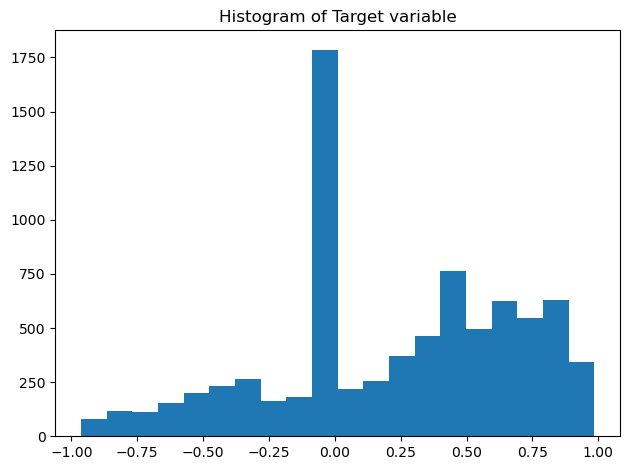

In [250]:
plt.close('all')
plot_y_continous(y, bins=20, title='Histogram of Target variable')

In its simplest form, predictions of a linear regression model can be summarized as

$$
\hat{y} = \mathbf{w}^T \mathbf{x} = f(\mathbf{x},\mathbf{w})
$$

which can be optimized the cost functions 

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}, \mathbf{w}\right)\right)^{2}
$$

In [252]:
from sklearn import linear_model, svm, tree, metrics
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import ComplementNB
import sklearn.metrics as skm
import numpy as np

In [253]:
from imblearn.combine import SMOTEENN

In [332]:
#split X and y for training and validation purposes
X = df['words_str']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X_ = CountVectorizer(ngram_range = (1,2)).fit(X_train)
X_train = X_.transform(X_train)
X_val= (X_).transform(X_val)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

#create our linear regression model
# reg = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

Now fit a linear regression model on the training data.

In [335]:
reg = xgboost.XGBRegressor(n_jobs = -1, 
                                 eval_metric = 'rmse',
                                n_estimators = 500,
                                max_depth = 4,
                                booster = "gbtree",
                                eta = 0.35,
                                gamma = 0,
                                min_child_weight = 1,
                                subsample = 1,
                                alpha = 1
                                )
reg.fit(X_train, y_train)

XGBRegressor(alpha=1, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.35, eval_metric='rmse',
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, ...)

In [336]:
# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")


Split: train
	RMSE: 0.20
	MAE: 0.15

Split: valididation
	RMSE: 0.31
	MAE: 0.23


In [260]:
#plot the histogram of learnt weights w_i 
plot_y_continous(reg.coef_, bins=20, title='Histogram of Parameters (w) learnt')

AttributeError: Coefficients are not defined for Booster type gbtree

At this point, we can use our model to predict sentiments scores of tweets from `X_test`, i.e. test set. Do not forget to encode them as well.

And save your predictions `y_hat` by naming it with the following format. 

`<TEAM_ID>__<SPLIT>_reg_pred.npy`

Make sure that

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_1" during the semester and "test_2" for final submission. You will be notified when we need to move to "test_2".

In [280]:
# Run this to save a file with your predictions on the test set to be submitted

sentences = list(df_test.words_str.values)
# X_test = model.encode(sentences)
X_test = CountVectorizer(ngram_range = (1,2)).fit(df['words_str']).transform(sentences)
y_hat = reg.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_reg_pred.npy

folder = 'result'
np.save(os.path.join(folder, f'{team_id}__{split}__reg_pred.npy'), y_hat)


# Linear classification

In this part, we will solve a linear classification task to predict our target `sentiment`, i.e. sentiment class of tweets, using our features which are encodings of the tweets.


In [ ]:
from sklearn import linear_model
from sklearn import preprocessing
import numpy as np

In [ ]:
def plot_y_discrete(y, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    sns.countplot(x=y, palette=colors, ax=ax)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

In [ ]:
plot_y_discrete(df.sentiment)

We will first change our targets (classes; positive, neutral, negative) to numeric targets. Then, we solve a logistic regression problem by minimizing the multinomial cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} \mathbb{1}_{y_{i}=k} \log(p_{\theta}(\hat{y}=k | \mathbf{x}_{i}))
$$

where $y_i \in \{1,\ldots,K\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_{i})$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_{i}$.

In [ ]:
X = sentence_embeddings
y_text = df.sentiment.values
le = preprocessing.LabelEncoder()
le.fit(y_text)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y =le.transform(y_text)
print(f"X: {X.shape}")
print(f"y: {y.shape} {np.unique(y)}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]
clf = linear_model.LogisticRegression(penalty='none', 
                                      dual=False, 
                                      tol=0.0001, 
                                      C=1.0, 
                                      fit_intercept=True, 
                                      intercept_scaling=1, 
                                      class_weight=None, # None, balanced
                                      random_state=None, 
                                      solver='lbfgs', 
                                      max_iter=1000, 
                                      multi_class='auto', 
                                      verbose=0, 
                                      warm_start=False, 
                                      n_jobs=None, 
                                      l1_ratio=None
                                      
                                     )

In [ ]:

clf = linear_model.LogisticRegression(penalty='none', 
                                      dual=False, 
                                      tol=0.0001, 
                                      C=1.0, 
                                      fit_intercept=True, 
                                      intercept_scaling=1, 
                                      class_weight=None, # None, balanced
                                      random_state=None, 
                                      solver='lbfgs', 
                                      max_iter=1000, 
                                      multi_class='auto', 
                                      verbose=0, 
                                      warm_start=False, 
                                      n_jobs=None, 
                                      l1_ratio=None
                                      
                                     )

# MODEL

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
svc = SVC(class_weight = 'balanced', kernel = 'poly', coef0 = 1e-2)


In [ ]:
test_model(kf10, svc, X, y)

In [ ]:
test_model(kf10, svc, words12g75000_tfidf, y)

In [ ]:
svc_param = {
#     'C': [1.0, 0.5, 0.1],
    'kernel': ['poly'],
#     'degree': [3],
#     'gamma': ['scale', 'auto'],
    'coef0': [0, 0.1, 1e-2, 1e-3],
#     'tol': [1e-2, 1e-3, 1e-4],
    
}

In [ ]:
# svc = svc.fit(X_res, y_res)
svc_gscv = GridSearchCV(svc, param_grid = svc_param, n_jobs = -1, cv = kf5, scoring = metrics.f1_score, verbose = 3)

In [ ]:
svc_gscv = svc_gscv.fit(X_res, y_res)

In [ ]:
svc_gscv.best_params_

In [ ]:
X_res, y_res = SMOTE().fit_resample(X_train, y_train)

In [ ]:
Counter(y_res)

In [ ]:
datasets = [
    [X_res, y_res],
    [X_val, y_val]
]

In [ ]:

print(f"X: {X_res.shape}")
print(f"y: {y_res.shape} {np.unique(y)}")

Fit your model by using training data.

In [ ]:
clf = clf.fit(X_res, y_res)


In [ ]:
y_pred = svc_gscv.predict(X_val)
rmse = np.sqrt(skm.mean_squared_error(y_val, y_pred))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
print(rmse)


Reminders about macro and micro averaging:


In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


Now evaluate your model

In [ ]:
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = svc.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

At this point, we can use our model to predict sentiments scores of tweets from `X_test`, i.e. test set. Do not forget to encode them as well.

And save your predictions `y_hat` by naming it with the following format. 

`<TEAM_ID>__<SPLIT>_clf_pred.npy`

Make sure that

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_1" during the semester and "test_2" for final submission. You will be notified when we need to move to "test_2".

In [279]:
# Run this to save a file with your predictions on the test set to be submitted
sentences = list(df_test.words_str.values)
X_test = model.encode(sentences)
y_hat = clf.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_clf_pred.npy

folder = 'result'
np.save(os.path.join(folder, f'{team_id}__{split}__clf_pred.npy'), y_hat)

KeyboardInterrupt: 

# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy` \

Above, `<SPLIT>` should correspond to `test_1` for the leaderboard and `test_2` for the final submission. 

In [ ]:
res = np.load('result/1__test_1__reg_pred.npy')

In [ ]:
res